<a href="https://colab.research.google.com/github/ab2gbl/ECG-detection/blob/main/QRS_detection/TCN/TCN_QTDB%2BLUDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cp -r '/content/drive/MyDrive/Final project/dataset/physionet.org' '/content/physionet.org'

In [2]:
!pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 75.9 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [3]:
import wfdb
from scipy.signal import butter, filtfilt
import numpy as np
from scipy.signal import resample
from re import S
import os

In [4]:
def bandpass_filter(signal, lowcut=0.5, highcut=40, fs=250, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)
def smooth_signal(data, window_size=5):
    # Smooth the signal using a moving average filter
    window = np.ones(window_size) / window_size
    smoothed = np.convolve(data, window, mode='same')
    return smoothed

In [5]:
def extract_qrs_regions(samples, symbols, fs, extra_ms=0):

    qrs_regions = []
    start = None
    nested_count = 0  # Track nested parentheses
    current_symbol = None  # Track if 'N' appears
    extra_samples = int((extra_ms / 1000) * fs)  # Convert ms to samples
    for i in range(len(symbols)):
        if symbols[i] == '(':
            if nested_count == 0:  # First `(` marks the start
                start = samples[i]
                current_symbol = None  # Reset tracking
            nested_count += 1  # Increase nested count

        elif symbols[i] == 'N':  # Identify QRS region
            current_symbol = 'N'

        elif symbols[i] == ')':
            nested_count -= 1  # Reduce nested count
            if nested_count == 0 and start is not None:
                if current_symbol == 'N':  # Only save if 'N' was in the segment
                    end = samples[i] + extra_samples
                    qrs_regions.append((start, end))
                start = None
                current_symbol = None  # Reset tracking

    return qrs_regions



In [6]:


def resample_signal(signal, original_fs, target_fs):
    num_samples = int(len(signal) * target_fs / original_fs)
    resampled_signal = resample(signal, num_samples)
    return resampled_signal


def adjust_annotations(samples, original_fs, target_fs):
    return (samples * target_fs / original_fs).astype(int)



In [7]:

def create_binary_mask(signal, qrs_regions):
    mask = np.zeros(len(signal))
    for start, end in qrs_regions:
        mask[start:end] = 1  # Mark QRS regions as 1
    return mask


In [8]:
def segment_signal_and_mask(signal, mask, window_size, fs):
    segments = []
    masks = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        mask_segment = mask[i:i + window_size]
        segments.append(segment)
        masks.append(mask_segment)
    return np.array(segments), np.array(masks)


In [9]:

def process_record(record_path, Type, extra_ms=0):
    # Load signal
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, 0]  # Use lead I
    if Type=='QTDB':
      annotations = wfdb.rdann(record_path, 'pu')
    else:
      annotations = wfdb.rdann(record_path, 'i')
    samples = annotations.sample  # Annotation sample locations
    symbols = annotations.symbol  # Annotation symbols
    fs = record.fs  # Sampling frequency (500 Hz)

    # Preprocess
    signal = smooth_signal(bandpass_filter(signal))

    # Extract QRS
    if Type=='QTDB':
      qrs_regions = extract_qrs_regions(samples, symbols,fs,extra_ms=extra_ms)
    else :
      qrs_regions = extract_qrs_regions(samples, symbols,fs)

    # Resampling to 250 Hz
    if fs!=250:
      # Example: Resample QTDB signal from 500 Hz to 250 Hz
      signal = resample_signal(signal, original_fs=fs, target_fs=250)


      # Example: Adjust QTDB annotations
      qrs_regions = [(adjust_annotations(start, original_fs=fs, target_fs=250),
                                  adjust_annotations(end, original_fs=fs, target_fs=250))
                                  for start, end in qrs_regions]
      fs=250

    # Create binary masks
    mask = create_binary_mask(signal, qrs_regions)


    # Segment the signals and masks
    window_size = int(1 * fs)  # 1-second window (based on LUDB's fs)
    segments, masks = segment_signal_and_mask(signal, mask, window_size, fs)

    return segments, masks


In [10]:
def get_all_records(directory, extension=".dat"):
    files = [f.replace(extension, "") for f in os.listdir(directory) if f.endswith(extension)]
    return list(set(files))  # Ensure no duplicates

# Set paths for QTDB and LUDB
qtdb_path = "/content/physionet.org/files/qtdb/1.0.0/"
ludb_path = "/content/physionet.org/files/ludb/1.0.1/data/"

# Get all record names dynamically
qt_records = get_all_records(qtdb_path)
lu_records = get_all_records(ludb_path)

print(f"Found {len(qt_records)} QTDB records and {len(lu_records)} LUDB records.")

Found 105 QTDB records and 200 LUDB records.


In [11]:
qt_segments_list, qt_masks_list = [], []

for record_path in qt_records:
    try:
        print(f"Processing {record_path}")
        segments, masks = process_record(qtdb_path+record_path, Type='QTDB', extra_ms=20)  # Resample to 250 Hz
        qt_segments_list.append(segments)
        qt_masks_list.append(masks)
    except:
        print(f"Skipping {record_path} due to error.")

Processing sele0133
Processing sel811
Processing sele0116
Processing sel306
Processing sele0124
Processing sel51
Processing sel803
Processing sele0612
Processing sel883
Processing sel45
Processing sele0112
Processing sele0106
Processing sel47
Processing sel48
Processing sel820
Processing sele0110
Processing sel117
Processing sel100
Processing sel33
Processing sel103
Processing sel232
Processing sel872
Processing sele0405
Processing sel104
Processing sel840
Processing sel16265
Processing sel49
Processing sele0409
Processing sel38
Processing sel302
Processing sel39
Processing sel223
Processing sel52
Processing sele0609
Processing sele0303
Processing sele0203
Processing sele0406
Processing sel213
Processing sel16272
Processing sel15814
Processing sel853
Processing sel16786
Processing sel231
Processing sele0121
Processing sel14046
Processing sele0604
Processing sele0509
Processing sel36
Processing sel30
Processing sel116
Processing sel14172
Processing sel44
Processing sele0129
Processing s

In [12]:

lu_segments_list, lu_masks_list = [], []
for record_path in lu_records:
    try:
        print(f"Processing {record_path}")
        segments, masks = process_record(ludb_path+record_path, Type='LUDB', extra_ms=0)
        lu_segments_list.append(segments)
        lu_masks_list.append(masks)
    except:
        print(f"Skipping {record_path} due to error.")

Processing 61
Processing 73
Processing 188
Processing 79
Processing 46
Processing 16
Processing 87
Processing 67
Processing 23
Processing 149
Processing 35
Processing 173
Processing 162
Processing 22
Processing 43
Processing 12
Processing 41
Processing 101
Processing 156
Processing 137
Processing 99
Processing 146
Processing 130
Processing 107
Processing 89
Processing 187
Processing 20
Processing 10
Processing 75
Processing 134
Processing 190
Processing 30
Processing 139
Processing 39
Processing 164
Processing 144
Processing 161
Processing 136
Processing 142
Processing 49
Processing 5
Processing 11
Processing 121
Processing 72
Processing 175
Processing 45
Processing 4
Processing 40
Processing 54
Processing 170
Processing 199
Processing 53
Processing 166
Processing 160
Processing 127
Processing 140
Processing 56
Processing 65
Processing 55
Processing 94
Processing 135
Processing 2
Processing 100
Processing 122
Processing 57
Processing 191
Processing 116
Processing 148
Processing 114
Pro

In [13]:
qt_segments = np.concatenate(qt_segments_list, axis=0)
qt_masks = np.concatenate(qt_masks_list, axis=0)
lu_segments = np.concatenate(lu_segments_list, axis=0)
lu_masks = np.concatenate(lu_masks_list, axis=0)

In [14]:
# Combine into final dataset
X = np.concatenate([qt_segments, lu_segments])
y = np.concatenate([qt_masks, lu_masks])

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, ReLU, Add, Dense

def TCN(input_shape, num_filters, kernel_size, num_blocks, dropout_rate):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_blocks):
        # Residual block
        res = x
        x = Conv1D(num_filters, kernel_size, padding='causal')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv1D(num_filters, kernel_size, padding='causal')(x)
        x = BatchNormalization()(x)
        x = Add()([x, res])
        x = ReLU()(x)
    x = Conv1D(1, kernel_size=1, activation='sigmoid')(x)  # Output sequence of probabilities
    model = Model(inputs, x)
    return model
window_size=int(1*250)
# Define the TCN model
input_shape = (window_size, 1)
model = TCN(input_shape, num_filters=64, kernel_size=3, num_blocks=4, dropout_rate=0.2)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 250, 1)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 250, 64)        │            256 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 250, 64)        │            256 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 250, 64)        │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 250, 64)        │         12,352 │ re_lu[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 250, 64)        │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 250, 64)        │              0 │ batch_normalization_1… │
│                           │                        │                │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 250, 64)        │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 250, 64)        │         12,352 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 250, 64)        │            256 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 250, 64)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 250, 64)        │         12,352 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 250, 64)        │            256 │ conv1d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 250, 64)        │              0 │ batch_normalization_3… │
│                           │                        │                │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 250, 64)        │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 250, 64)        │         12,352 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 88,833 (347.00 KB)

 Trainable params: 87,809 (343.00 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [18]:
# Reshape data for TCN input
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=32)

Epoch 1/2
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.9589 - loss: 0.1188 - val_accuracy: 0.9474 - val_loss: 0.1600
Epoch 2/2
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 45s 7ms/step - accuracy: 0.9596 - loss: 0.1172 - val_accuracy: 0.9478 - val_loss: 0.1549


1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9479 - loss: 0.1536
Test Accuracy: 0.9483315944671631
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


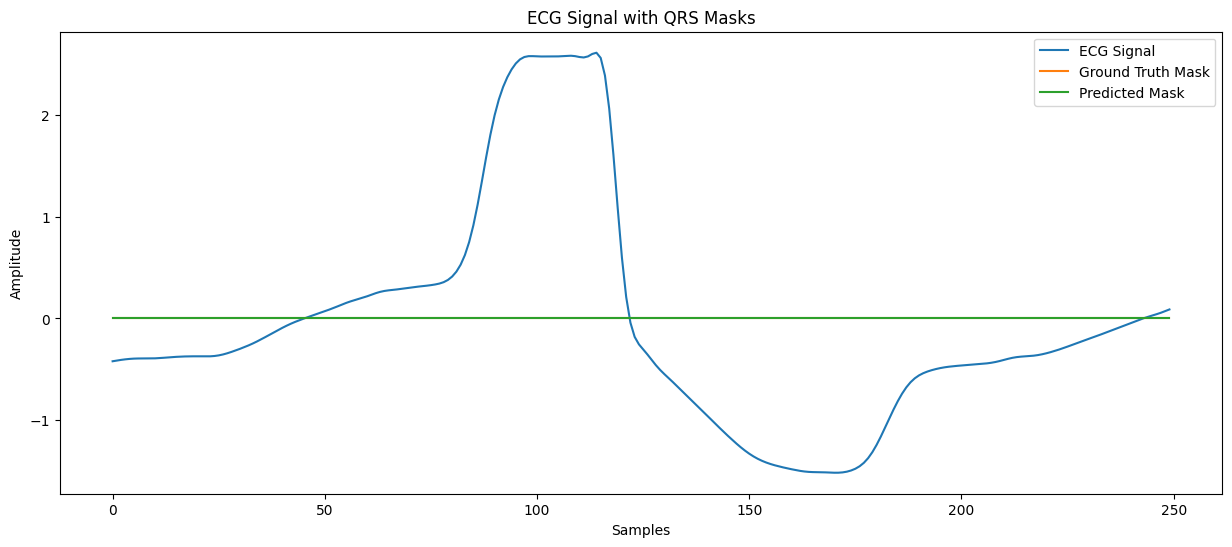

In [19]:
# Evaluate on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Predict on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks

# Visualize predictions
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(X_test[0].flatten(), label='ECG Signal')
plt.plot(y_test[0].flatten(), label='Ground Truth Mask')
plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.title('ECG Signal with QRS Masks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [29]:
from keras.saving import save_model

# Save the trained model
save_model(model,"/content/drive/MyDrive/Final project/QRS detection/TCN/First_model.keras")
model.save("/content/drive/MyDrive/Final project/QRS detection/TCN/First_model.keras")

In [20]:
import wfdb

# Load the new ECG signal
new_record = wfdb.rdrecord('/content/physionet.org/files/mitdb/1.0.0/100')

new_signal = new_record.p_signal[:, 0]  # Use lead I
new_fs = new_record.fs  # Sampling frequency

# Extract the first 10 seconds
first_10_seconds = new_signal[:int(10 * new_fs)]
print(first_10_seconds.shape)

(3600,)


In [21]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

first_10_seconds = smooth_signal(bandpass_filter(first_10_seconds))

first_10_seconds = resample_signal(first_10_seconds, original_fs=new_fs, target_fs=250)
# Segment the signal into fixed-length windows
def segment_signal(signal, window_size, fs):
    segments = []
    for i in range(0, len(signal) - window_size, window_size // 2):  # 50% overlap
        segment = signal[i:i + window_size]
        segments.append(segment)
    return np.array(segments)

window_size = int(1 * new_fs)  # 1-second window
new_segments = segment_signal(first_10_seconds, window_size, new_fs)

# Reshape for TCN input
new_segments = new_segments.reshape(-1, window_size, 1)
print(new_segments.shape)

(12, 360, 1)


In [25]:
# Predict QRS regions
y_pred = model.predict(new_segments)
print(y_pred)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary masks
print(y_pred[y_pred > 0])  # P
# Combine predictions into a single mask
full_mask = np.zeros(len(first_10_seconds))
for i, segment in enumerate(new_segments):
    start = i * (window_size // 2)
    end = start + window_size
    full_mask[start:end] = np.maximum(full_mask[start:end], y_pred[i].flatten())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[[0.04339973]
  [0.01087367]
  [0.11412638]
  ...
  [0.00255247]
  [0.00841713]
  [0.01793549]]

 [[0.04302762]
  [0.04373029]
  [0.0637029 ]
  ...
  [0.00209623]
  [0.00279625]
  [0.00240817]]

 [[0.04512674]
  [0.01964025]
  [0.07437376]
  ...
  [0.07257568]
  [0.06968116]
  [0.03432009]]

 ...

 [[0.03696239]
  [0.03176602]
  [0.07348862]
  ...
  [0.0086012 ]
  [0.00226102]
  [0.00825055]]

 [[0.04386422]
  [0.0287993 ]
  [0.06412005]
  ...
  [0.00214034]
  [0.0029206 ]
  [0.00211883]]

 [[0.0501109 ]
  [0.01695802]
  [0.06101495]
  ...
  [0.11917186]
  [0.05310471]
  [0.35933647]]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [26]:
def extract_qrs_from_mask(mask):
    qrs_regions = []
    start = None
    for i in range(len(mask)):
        if mask[i] == 1 and start is None:  # Start of QRS region
            start = i
        elif mask[i] == 0 and start is not None:  # End of QRS region
            end = i
            qrs_regions.append((start, end))
            start = None
    return qrs_regions

qrs_regions = extract_qrs_from_mask(full_mask)
print(qrs_regions)

[(45, 64), (65, 66), (244, 245), (249, 268), (269, 271), (451, 452), (453, 471), (472, 473), (642, 643), (644, 647), (649, 668), (669, 671), (848, 865), (1040, 1041), (1045, 1062), (1249, 1267), (1268, 1270), (1410, 1417), (1419, 1430), (1431, 1433), (1655, 1658), (1662, 1681), (1682, 1683), (1868, 1890), (1891, 1892), (2053, 2054), (2071, 2092), (2093, 2095), (2269, 2272), (2273, 2290), (2291, 2293)]


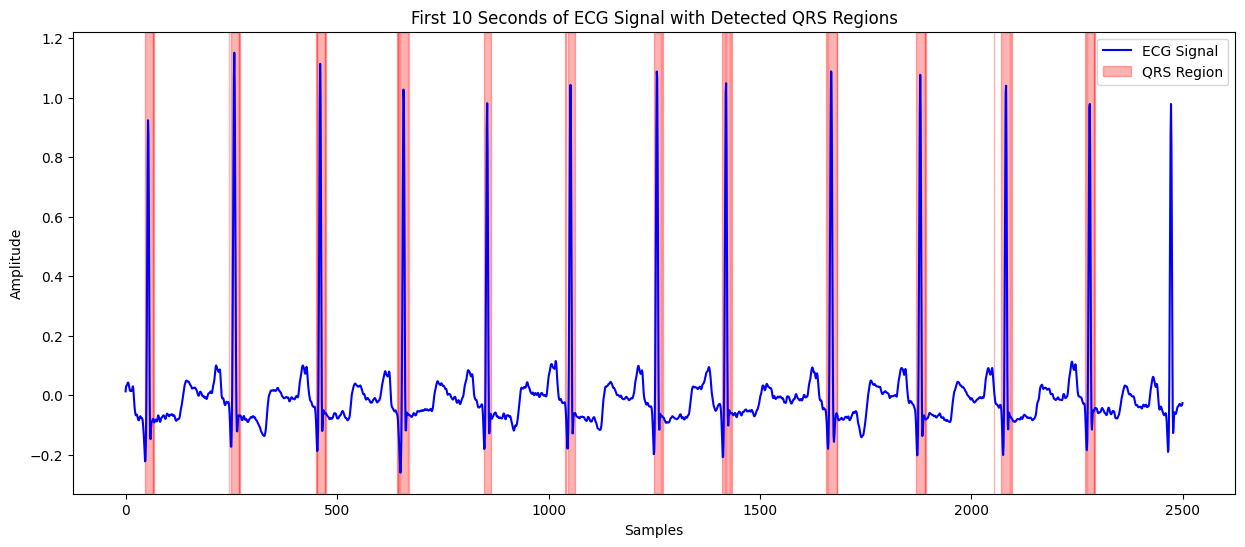

In [27]:
import matplotlib.pyplot as plt

# Plot the first 10 seconds of the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(first_10_seconds, label='ECG Signal', color='b')

# Highlight QRS regions
for start, end in qrs_regions:
    plt.axvspan(start, end, color='r', alpha=0.3, label='QRS Region' if start == qrs_regions[0][0] else "")

plt.title('First 10 Seconds of ECG Signal with Detected QRS Regions')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
#plt.plot(y_pred[0].flatten(), label='Predicted Mask')
plt.legend()
plt.show()